## PushT dataset for real robot from the authors of the paper


In [11]:
import zarr
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# ⚠️ REPLACE this with the actual path to the unzipped Zarr folder
# E.g., 'pusht_cchi_v7_replay.zarr'
DATASET_PATH = '/home/vinoth/BTP/data/pusht_real/real_pusht_20230105/replay_buffer.zarr'

# Open the main Zarr group in read-only mode
try:
    data_root = zarr.open_group(DATASET_PATH, mode='r')
except FileNotFoundError:
    print(f"Error: Could not find the dataset at '{DATASET_PATH}'.")
    print("Make sure you unzipped the file and updated the DATASET_PATH variable.")
    exit()

print("--- Overall Zarr Group Structure ---")
# print(data_root.info)
print("-" * 40)

--- Overall Zarr Group Structure ---
----------------------------------------


In [3]:
data_root["data"].info

Name,/data
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,7
No. arrays,7
No. groups,0
Arrays,"action, robot_eef_pose, robot_eef_pose_vel, robot_joint, robot_joint_vel, stage, timestamp"


In [4]:
len(data_root["data"]["action"])

27672

In [8]:
data_root['meta']

<zarr.hierarchy.Group '/meta' read-only>

### There are 162 files inside Data/Actions or Data/Robot_eef_pose etc.

In [10]:
print(f"Total number of actions: {len(data_root['data']['action'])}")

Total number of actions: 27672


In [ ]:
data_root["data"]["action"][0]

array([ 5.33741924e-01, -6.50096626e-03,  4.22350925e-02, -2.22198119e+00,
        2.22082343e+00, -2.30840876e-05])

In [ ]:
7

array([ 5.33724613e-01, -6.52989449e-03,  4.22136087e-02,  2.22196928e+00,
       -2.22090191e+00,  1.84449548e-06])

In [ ]:
data_root["data"]["robot_eef_pose_vel"][0]

array([ 1.64916926e-05,  3.04604823e-05,  2.01637813e-05,  1.87639207e-05,
       -9.56481523e-05,  1.23038044e-04])

In [ ]:
data_root["data"]["robot_joint"][0]

array([ 0.19371189, -1.85587055, -1.95218307, -0.90434152,  1.57079077,
        0.1932314 ])

In [ ]:
data_root["data"]["robot_joint_vel"][0]

array([ 5.11326944e-05,  2.55663472e-05, -0.00000000e+00,  7.19053496e-05,
        0.00000000e+00, -7.19053496e-05])

In [ ]:
print(f'Timestamp index 0: {data_root["data"]["timestamp"][0]}')
print(f'Timestamp index 27671: {data_root["data"]["timestamp"][27671]}')

Timestamp index 0: 1672955667.4093015
Timestamp index 27671: 1672975869.031702


In [ ]:
data_root["data"]["timestamp"][27671] - data_root["data"]["timestamp"][0]

20201.622400522232

In [ ]:
20201/162

124.69753086419753

In [11]:
data_root["meta"]["episode_ends"][:]

array([  170,   352,   553,   779,   978,  1211,  1355,  1483,  1728,
        1888,  2125,  2281,  2487,  2736,  2951,  3120,  3365,  3567,
        3870,  4142,  4329,  4546,  4750,  4908,  5018,  5368,  5599,
        5815,  6051,  6257,  6528,  6674,  6947,  7220,  7451,  7742,
        8048,  8282,  8412,  8595,  8730,  8923,  9103,  9165,  9344,
        9547,  9762, 10029, 10318, 10593, 10711, 10851, 11058, 11237,
       11466, 11779, 12108, 12378, 12581, 12751, 12924, 13158, 13297,
       13532, 13691, 13900, 14065, 14240, 14368, 14585, 14867, 15106,
       15387, 15621, 15833, 15990, 16183, 16377, 16598, 16770, 17033,
       17255, 17420, 17643, 17841, 18035, 18256, 18429, 18711, 18888,
       19032, 19223, 19484, 19610, 19817, 19995, 20129, 20276, 20438,
       20666, 20799, 20904, 21142, 21328, 21581, 21740, 22003, 22169,
       22345, 22561, 22789, 22941, 23168, 23353, 23554, 23760, 24009,
       24148, 24426, 24646, 24861, 25002, 25186, 25347, 25647, 25873,
       26071, 26314,

In [12]:
from replaybuffer import ReplayBuffer

In [13]:
import zarr
import numpy as np
import os
import matplotlib.pyplot as plt

# ======================================================================
# --- CONFIGURATION (UPDATE THIS) ---
# ======================================================================

# ⚠️ 1. Change this to the path where your PUSH-T dataset is located.
# After unzipping 'pusht_real.zip', it becomes a directory (e.g., 'pusht_cchi_v7_replay.zarr').
# Use the *unzipped directory name* here.
DATASET_PATH = '/home/vinoth/BTP/data/pusht_cchi_v7_replay.zarr' 

# 2. Define the keys based on the structure we previously identified
STATE_KEYS = [
    'robot_eef_pose', 'robot_eef_pose_vel', 
    'robot_joint', 'robot_joint_vel', 'stage'
]
IMAGE_KEY = 'rgb_static'

# ======================================================================
# --- DATA LOADING AND INSPECTION ---
# ======================================================================

if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path '{DATASET_PATH}' not found. Please update the path to the 'replay_buffer.zarr' location.")
    print("Example: If your notebook is in the 'pusht_real' folder, the path should look like 'real_pusht_20230105/replay_buffer.zarr'.")
else:
    try:
        # 1. Open Zarr root
        data_root = zarr.open_group(DATASET_PATH, mode='r')
        
        # 2. Access the episode group (assumes data is nested under 'data')
        # The structure inside replay_buffer.zarr is: Root -> 'data' (episodes) and Root -> 'rgb_static' (images)
        episode_group = data_root['data']
        # episode_keys = sorted([k for k in episode_group.keys() if k.isdigit()], key=int)
        episode_keys = list(episode_group.keys())
        
        if not episode_keys:
            print("No episodes found under 'data'. Check your Zarr structure.")
            raise FileNotFoundError

        target_episode_key = episode_keys[0]
        ep_lowdim_data = episode_group[target_episode_key]
        ep_image_data = data_root[IMAGE_KEY][target_episode_key]
        
        print(f"--- Loading Episode {target_episode_key} ---")

        # 3. Load all low-dimensional state components for the episode
        state_components = []
        for key in STATE_KEYS:
            state_components.append(ep_lowdim_data[key][:])
        
        # Concatenate into the final state vector (T, State_Dimension)
        full_state_obs = np.concatenate(state_components, axis=1).astype(np.float32)

        # 4. Load actions (T, Action_Dimension)
        actions = ep_lowdim_data['action'][:].astype(np.float32)

        # 5. Load and process image data
        # Raw shape: (T, H, W, C) -> Processed shape: (T, C, H, W), range [0, 1]
        images_raw = ep_image_data[:]
        images_processed = np.moveaxis(images_raw, -1, 1).astype(np.float32) / 255.0

        T = len(actions)

        # 6. Display results for the first timestep (t=0)
        t = 0
        current_state = full_state_obs[t]
        current_image = images_processed[t]
        current_action = actions[t]
        
        print("\n--- Data Structure Ready for Training ---")
        print(f"Total Timesteps (T): {T}")
        print(f"State Observation Shape: {full_state_obs.shape} (Combined Low-Dim)")
        print(f"Image Observation Shape: {images_processed.shape} (T, C, H, W)")
        print(f"Action Shape: {actions.shape}")
        
        print(f"\n--- Timestep t={t} Sample Data ---")
        print(f"State Vector (first 5 elements): {current_state[:5]}")
        print(f"Action Vector: {current_action}")
        
        # Visualization (requires image to be (H, W, C) for Matplotlib)
        plt.imshow(np.moveaxis(current_image, 0, 2))
        plt.title(f"Image Observation at t={t}")
        plt.axis('off')
        plt.show()


    except Exception as e:
        print(f"\nAn error occurred during data processing: {e}")
        print("Ensure the path to 'replay_buffer.zarr' is correct.")



An error occurred during data processing: 'rgb_static'
Ensure the path to 'replay_buffer.zarr' is correct.


In [ ]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
dataset_path = '/home/vinoth/BTP/data/pusht_cchi_v7_replay.zarr'
dataset_root = zarr.open(dataset_path, 'r')

# float32, [0,1], (N,96,96,3)
train_image_data = dataset_root['data']['img']

IndexError: invalid 'fields' argument, array does not have any fields

In [15]:
len(train_image_data)

25650

### It has 160 files

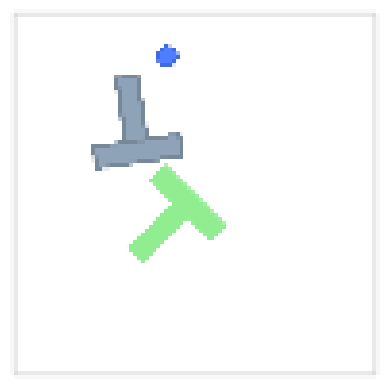

In [24]:
plt.imshow(train_image_data[279].astype("uint8"))  # ensure dtype is uint8 [0-255]
plt.axis("off")
plt.show()

In [17]:
from PIL import Image

# convert numpy array -> Image
im = Image.fromarray(train_image_data[0].astype("uint8"))
im.show()

In [18]:
dataset_root['data']['state'][0]

array([222.       ,  97.       , 222.99382  , 381.59903  ,   3.0079994],
      dtype=float32)

In [19]:
dataset_root['meta']['episode_ends'][:]

array([  161,   279,   420,   579,   738,   895,   964,  1133,  1213,
        1347,  1535,  1684,  1824,  1949,  2056,  2209,  2335,  2437,
        2523,  2598,  2740,  2855,  2964,  3074,  3172,  3305,  3463,
        3575,  3682,  3797,  3881,  3976,  4124,  4244,  4386,  4529,
        4671,  4792,  4978,  5077,  5216,  5289,  5425,  5543,  5670,
        5822,  5905,  6014,  6152,  6235,  6304,  6377,  6513,  6686,
        6891,  6997,  7102,  7185,  7303,  7425,  7485,  7635,  7702,
        7842,  7945,  8111,  8178,  8282,  8372,  8522,  8708,  8842,
        8990,  9102,  9220,  9318,  9407,  9529,  9705,  9775,  9892,
       10005, 10099, 10238, 10318, 10429, 10533, 10648, 10729, 10867,
       10976, 11077, 11155, 11219, 11286, 11393, 11583, 11694, 11762,
       11844, 11961, 12053, 12167, 12308, 12445, 12520, 12646, 12843,
       12955, 13100, 13231, 13329, 13400, 13549, 13714, 13811, 13989,
       14105, 14207, 14328, 14393, 14530, 14649, 14854, 15002, 15161,
       15332, 15473,

--- Image Check Results ---
Raw Shape (H, W, C): (96, 96, 3), Dtype: float32
Processed Shape (C, H, W): (3, 96, 96), Dtype: float32
Min/Max Value (Normalized): 0.2549 / 1.0000


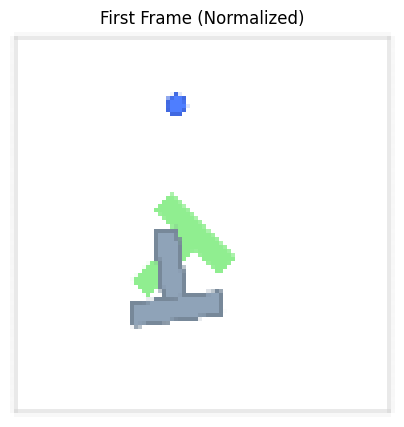

In [25]:
normalized_frame = train_image_data[0].astype(np.float32) / 255.0

# 2. Reorder channels (H, W, C) -> (C, H, W) for PyTorch input format
processed_frame_c_h_w = np.moveaxis(normalized_frame, -1, 0)

print("--- Image Check Results ---")
print(f"Raw Shape (H, W, C): {train_image_data[0].shape}, Dtype: {train_image_data[0].dtype}")
print(f"Processed Shape (C, H, W): {processed_frame_c_h_w.shape}, Dtype: {processed_frame_c_h_w.dtype}")
print(f"Min/Max Value (Normalized): {processed_frame_c_h_w.min():.4f} / {processed_frame_c_h_w.max():.4f}")

# --- 3. VISUALIZATION ---
# Convert back to (H, W, C) for Matplotlib plotting
frame_for_plot = np.moveaxis(processed_frame_c_h_w, 0, -1)

plt.figure(figsize=(5, 5))
plt.imshow(frame_for_plot)
plt.title("First Frame (Normalized)")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [65.0..255.0].


--- Raw Image Distribution Check (uint8, 0-255) ---
Raw Shape (H, W, C): (96, 96, 3), Dtype: float32
Mean Pixel Value: 249.05
Standard Deviation: 22.18
Min/Max Value: 65 / 255

Note: The data is not normally distributed; it's discrete (uint8) and bounded (0-255).


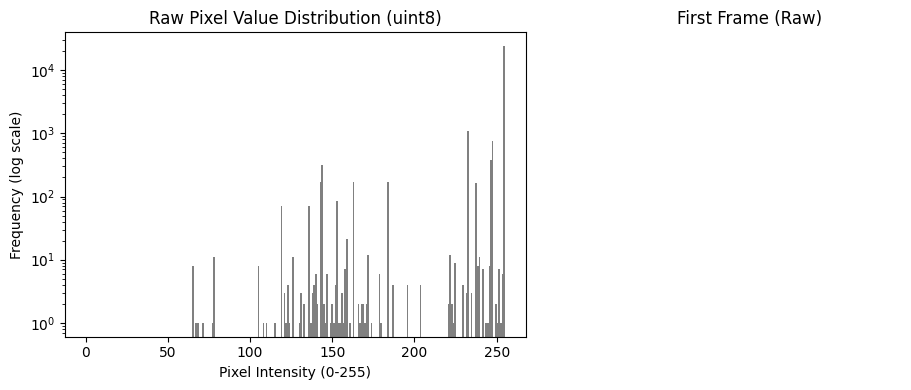

In [26]:
raw_pixel_values = train_image_data[0].astype(np.uint8).flatten()
raw_mean = np.mean(raw_pixel_values)
raw_std = np.std(raw_pixel_values)
raw_min = raw_pixel_values.min()
raw_max = raw_pixel_values.max()

print("--- Raw Image Distribution Check (uint8, 0-255) ---")
print(f"Raw Shape (H, W, C): {train_image_data[0].shape}, Dtype: {train_image_data[0].dtype}")
print(f"Mean Pixel Value: {raw_mean:.2f}")
print(f"Standard Deviation: {raw_std:.2f}")
print(f"Min/Max Value: {raw_min} / {raw_max}")
print("\nNote: The data is not normally distributed; it's discrete (uint8) and bounded (0-255).")

# --- 3. VISUALIZATION (Histogram) ---
plt.figure(figsize=(10, 4))

# Subplot 1: Histogram of Raw Pixels
plt.subplot(1, 2, 1)
plt.hist(raw_pixel_values, bins=256, range=(0, 255), color='gray', log=True)
plt.title("Raw Pixel Value Distribution (uint8)")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency (log scale)")

# Subplot 2: Display the image itself
plt.subplot(1, 2, 2)
plt.imshow(train_image_data[0])
plt.title("First Frame (Raw)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
import torch
import math

In [28]:
torch.exp?

print(f'\ntensor exp: {torch.exp(torch.tensor([1.0, 2.0, 3.0]))}')


tensor exp: tensor([ 2.7183,  7.3891, 20.0855])


Docstring:
exp(input, *, out=None) -> Tensor

Returns a new tensor with the exponential of the elements
of the input tensor :attr:`input`.

.. math::
    y_{i} = e^{x_{i}}

Args:
    input (Tensor): the input tensor.

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> torch.exp(torch.tensor([0, math.log(2.)]))
    tensor([ 1.,  2.])
Type:      builtin_function_or_method

In [29]:
math.log(1000) # base to e

6.907755278982137

In [30]:
x = torch.randn(2, 3, generator=torch.Generator().manual_seed(42))
x_normalized = (x - x.mean()) / x.std()
print(x_normalized.std())  # This will print 1.0 (or very close due to floating point)

tensor(1.)


# OWN DATASET

In [67]:
DATASET_PATH = '/home/vinoth/BTP/data_collection/test_dataset/session_20251229_230443.zarr'

# Open the main Zarr group in read-only mode
try:
    data_root = zarr.open_group(DATASET_PATH, mode='r')
except FileNotFoundError:
    print(f"Error: Could not find the dataset at '{DATASET_PATH}'.")
    print("Make sure you unzipped the file and updated the DATASET_PATH variable.")
    exit()

In [68]:
data_root['data']

<zarr.hierarchy.Group '/data' read-only>

In [69]:
data_root['data']['img'][0].dtype

dtype('float32')

In [71]:
from PIL import Image

arr = data_root['data']['img'][90]

arr_uint8 = (arr * 255).clip(0, 255).astype(np.uint8)
img = Image.fromarray(arr_uint8, mode="RGB")

img.show()        # visualize
img.save("img.png")

/tmp/ipykernel_8966/2165082421.py:6: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(arr_uint8, mode="RGB")


In [72]:
data_root['data']['state']

<zarr.core.Array '/data/state' (100, 6) float32 read-only>

In [73]:
data_root['data']['timestamp'][0]

1767029685.962982